# Posters

Draw a histogram of height distribution and find the minium and maximum pixel values

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from config import images_directory
import random
import numpy as np
from keras.utils import Sequence

def draw_height_histogram():
    image_heights = []
    min_pixel_value = np.inf
    max_pixel_value = -np.inf

    for filename in os.listdir(images_directory):
        image_path = os.path.join(images_directory, filename)
        image = cv2.imread(image_path)

        height = image.shape[0]

        image_heights.append(height)

        current_min = np.min(image)
        current_max = np.max(image)
        
        if current_min < min_pixel_value:
            min_pixel_value = current_min
        if current_max > max_pixel_value:
            max_pixel_value = current_max

    num_unique_heights = len(set(image_heights))

    plt.hist(image_heights, bins=num_unique_heights)
    plt.xlabel('Image Height')
    plt.ylabel('Frequency (log scale)')
    plt.yscale('log') 
    plt.title('Distribution of Image Heights')
    plt.show()

    print(f'min pixel values:{min_pixel_value}')
    print(f'max pixel values:{max_pixel_value}')

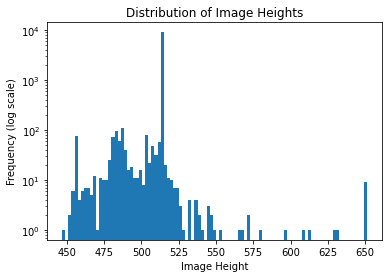

min pixel values:0
max pixel values:255


In [6]:
draw_height_histogram()

ImageDataLoader class used to load batches of images from the specified directory:
- images are split to training and test sets using the given ratio,
- each poster gets normalised,
- each image has it's height adjusted, so all posters have the same sizes before inputting them to the VAE.

In [2]:
class ImageDataLoader(Sequence):
    def __init__(self, directory, batch_size, desired_image_shape, train_split=0.8, shuffle=True):
        self.directory = directory
        self.batch_size = batch_size
        self.desired_image_shape = desired_image_shape
        self.train_split = train_split
        self.shuffle = shuffle

        # Get the list of image file names
        self.image_files = os.listdir(self.directory)

        # Shuffle the image files if required
        if self.shuffle:
            random.shuffle(self.image_files)

        # Split the image files into training and validation sets
        split_index = int(len(self.image_files) * self.train_split)
        self.train_files = self.image_files[:split_index]
        self.val_files = self.image_files[split_index:]
    
    def get_train_test_data(self):
        return self.train_files, self.val_files

    def __len__(self):
        # Calculate the number of batches per epoch
        return int(np.ceil(len(self.train_files) / self.batch_size))

    def __getitem__(self, index):
        # Get the batch of image file names
        batch_files = self.train_files[index * self.batch_size:(index + 1) * self.batch_size]

        # Load and preprocess the batch of images
        batch_images = []
        for file in batch_files:
            image_path = os.path.join(self.directory, file)
            image = cv2.imread(image_path)

            # Preprocess the image

            image = image.astype('float32') / 255.0  # Normalize pixel values to [0, 1]

            resized_image = cv2.resize(image, (self.desired_image_shape[1], self.desired_image_shape[0])) # Resize the image to the desired width and height

            batch_images.append(resized_image)

        # Convert the batch of images to NumPy array
        batch_images = np.array(batch_images)

        return batch_images

    def on_epoch_end(self):
        # Shuffle the training image files at the end of each epoch
        if self.shuffle:
            random.shuffle(self.train_files)

Instantiate the ImageDataLoader class with a desired image shape and build the Variational Autoencoder

In [3]:
from variational_autoencoder import VariationalAutoencoder

desired_image_shape = (216, 256)
batch_size = 16
image_data_loader = ImageDataLoader(directory=images_directory, batch_size=batch_size, desired_image_shape=desired_image_shape, train_split=0.15)

vae = VariationalAutoencoder(input_width=desired_image_shape[0], input_height=desired_image_shape[1], latent_dim=32)

input_shape = (None,) + desired_image_shape + (3,)
vae.build(input_shape)
vae.compile_model()

vae.summary()
vae.encoder.summary()
vae.decoder.summary()

Model: "variational_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        [(None, 32),              3634336   
                              (None, 32),                        
                              (None, 32)]                        
                                                                 
 decoder (Functional)        (None, 216, 256, 3)       3890243   
                                                                 
Total params: 7,524,579
Trainable params: 7,524,579
Non-trainable params: 0
_________________________________________________________________
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 216, 256, 3  0           []               

batch images shape: (16, 216, 256, 3)


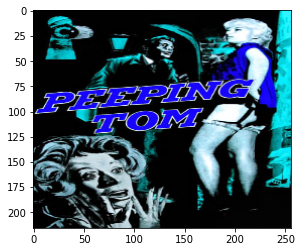

In [7]:
for batch in image_data_loader:
    plt.imshow(batch[0])
    break

Train the VAE model using the ImageDataLoader class

In [ ]:
vae.train(data_loader=image_data_loader, epochs=2)